# <img src="../assets/logo_infnetv1.png" alt="Infnet logo" height="45"/> Projeto de Disciplina de Redes Neurais com TensorFlow
<img src="https://img.shields.io/badge/python-v._3.11.5-blue?style=flat-square&logo=python&logoColor=white" alt="python_logo" height="20"/>
<img src="https://img.shields.io/badge/jupyter-v._5.7.2-blue?style=flat-square&logo=jupyter&logoColor=white" alt="jupyter_logo" height="20"/>
<img src="https://img.shields.io/badge/anaconda-v._23.7.4-blue?style=flat-square&logo=anaconda&logoColor=white" alt="anaconda_logo" height="20"/>

#### Grupo: 

- Mateus Teixeira Ramos da Silva <a href="https://github.com/GitMateusTeixeira/03-ml-modeling"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Fabio Ferreira Figueiredo <a href="https://github.com/fabioffigueiredo"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Wilson Melo <a href="https://github.com/bakudas"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Thiago Vinícius <a href="https://github.com/ubyss"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Lauro Barbosa <a href="https://github.com/LMRocha"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Felipe Szczpanski <a href="https://github.com/szczpanski"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>
- Iata Anderson <a href="https://github.com/AndersonSouza22"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/> </a>

### Sobre o projeto:

---

Se trata de um modelo de aprendizagem suprvisionado de classificação binária envolvendo dados relativos ao Câncer de Mama. Os dados foram extraídos do site do <a href="https://www.kaggle.com/datasets/wasiqaliyasir/breast-cancer-dataset">`Kaggle`</a>.

#### Convenções de reprodutibilidade:

- Todas as bibliotecas se encontram no arquivo `📄requirements.txt`
- Para mais informções, consulte nosso `README`

### Índice

---

- <a href='#parte-01-importar-os-pacotes'>Parte 01. Importar os pacotes</a>

- <a href='#parte-02-baixar-e-ler-os-dados'>Parte 02. Baixar e ler os dados</a>

- <a href='#parte-03-análise-exploratória'>Parte 03. Análise exploratória</a>

- <a href='#parte-04-tratamento-dos-dados-exclusão-da-coluna-nula'>Parte 04. Tratamento dos dados</a>

- <a href='#parte-05-verificando-a-correlação-entre-as-colunas'>Parte 05. Verificando a correlação entre as colunas</a>

- <a href='#parte-06-separar-as-features-utilizadas'>Parte 06. Separar as features</a>

- <a href='#parte-07-normalização-com-o-standard-scaller'>Parte 07. Normalização com o Standard Scaller</a>

- <a href='#parte-08-modelos-baseline'>Parte 08. Modelos baseline</a>

- - <a href='#81-criando-um-dumb-model-baseline-prevendo-tudo-como-a-classe-majoritária-para-validações-futuras'>8.1. Dumb model</a>

- - <a href='#82-criando-um-baseline-de-keras-padrão-sem-nenhum-finetuning'>8.2. Baseline com Keras padrão</a>

- <a href='#parte-09-grid-search-com-validação-cruzada'>Parte 09. Grid search com validação cruzada</a>

- <a href='#parte-10-comparação-dos-modelos'>Parte 10. Comparação dos modelos</a>

- <a href='#parte-11-streamlit'>Parte 11. Streamlit</a>

## Parte 01. Importar os pacotes

---

In [1]:
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, \
                            confusion_matrix, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from scikeras.wrappers import KerasClassifier
from tqdm.auto import tqdm


SEED = 42

pd.set_option("display.max_columns", 100)

# Silenciar os avisos do código
warnings.filterwarnings('ignore')

c:\Users\lauro\.conda\envs\infnetnn-trabalho-1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parte 02. Baixar e ler os dados

---

<a href='#índice'>Voltar ao início</a>

O arquivo será baixado diretamente do repositório do Kaggle. Caso a estrutura de pastas não exista, o algoritmo irá construí-la.

In [2]:
# Inicializar a API do Kaggle
api = KaggleApi()
api.authenticate()

# Criar o diretório se não existir
data_path = '../data/01-raw'
os.makedirs(data_path, exist_ok=True)

# Baixar os dados do Kaggle
api.dataset_download_files('wasiqaliyasir/breast-cancer-dataset', path=data_path, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/wasiqaliyasir/breast-cancer-dataset


In [3]:
path_raw = '../data/01-raw'
file_raw = 'Breast_cancer_dataset.csv'

pathfile_raw = os.path.join(path_raw, file_raw)

In [4]:
df = pd.read_csv(pathfile_raw)

## Parte 03. Análise exploratória

---

<a href='#índice'>Voltar ao início</a>

In [5]:
print(f"O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

O dataset possui 569 linhas e 33 colunas.


### 3.1. Visão geral do dataset

In [6]:
# Detalhando a base de dados com moda
def check(df):
    l = []
    colunas = df.columns
    
    for col in colunas:
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        sum_null = df[col].isnull().sum()

        # Calcula a moda e a frequência da moda
        moda = df[col].mode().iloc[0] if not df[col].mode().empty else "Não se aplica"
        moda_freq = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else "Não se aplica"

        if np.issubdtype(dtypes, np.number):
            status = df.describe(include='all').T
            media = status.loc[col, 'mean']
            std = status.loc[col, 'std']
            min_val = status.loc[col, 'min']
            quar1 = status.loc[col, '25%']
            mediana = df[col].median()
            quar3 = status.loc[col, '75%']
            max_val = status.loc[col, 'max']
                    
        else:
            status = "Não se aplica"
            media = "Não se aplica"
            std = "Não se aplica"
            min_val = "Não se aplica"
            quar1 = "Não se aplica"
            mediana = "Não se aplica"
            quar3 = "Não se aplica"
            max_val = "Não se aplica"

        l.append([col, dtypes, nunique, sum_null, media, std, min_val, quar1, mediana, quar3, max_val, moda, moda_freq])
    
    # Criação do DataFrame com as novas colunas
    df_check = pd.DataFrame(l)
    df_check.columns = ['coluna', 'tipo', 'únicos', 'null_soma', 'media', 'desvio', 
                        'minimo', '25%', 'mediana', '75%', 'maximo', 'moda', 'frequência_moda']
    
    return df_check 

In [7]:
# Análise geral dos dados
check(df)

,coluna,tipo,únicos,null_soma,media,desvio,minimo,25%,mediana,75%,maximo,moda,frequência_moda
0,id,int64,569,0,30371831.432337,125020585.612224,8670.0,869218.0,906024.0,8813129.0,911320502.0,8670,1
1,diagnosis,object,2,0,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,Não se aplica,B,357
2,radius_mean,float64,456,0,14.127292,3.524049,6.981,11.7,13.37,15.78,28.11,12.34,4
3,texture_mean,float64,479,0,19.289649,4.301036,9.71,16.17,18.84,21.8,39.28,14.93,3
4,perimeter_mean,float64,522,0,91.969033,24.298981,43.79,75.17,86.24,104.1,188.5,82.61,3
5,area_mean,float64,539,0,654.889104,351.914129,143.5,420.3,551.1,782.7,2501.0,512.2,3
6,smoothness_mean,float64,474,0,0.09636,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634,0.1007,5
7,compactness_mean,float64,537,0,0.104341,0.052813,0.01938,0.06492,0.09263,0.1304,0.3454,0.1147,3
8,concavity_mean,float64,537,0,0.088799,0.07972,0.0,0.02956,0.06154,0.1307,0.4268,0.0,13
9,concave points_mean,float64,542,0,0.048919,0.038803,0.0,0.02031,0.0335,0.074,0.2012,0.0,13


In [8]:
# Análise dos tipos das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

É possível verificar que o dataset original possui 33 colunas, das quais uma ('Unamed: 32') possui apenas dados nulos.

Além disso, com execeção da coluna 'diagnosis' (que é uma coluna categórica), as demais colunas são colunas numéricas, com informações sobre cada paciente.

### 3.2. Análise da distribuição dos dados

### 3.3. Pairplot - Análise de Relacionamentos entre Variáveis

O **Pairplot** (ou scatterplot matrix) é uma ferramenta fundamental na análise exploratória de dados (EDA). 
Este gráfico mostra, para cada par de variáveis numéricas, como elas se relacionam, além da distribuição individual 
em forma de histograma/densidade na diagonal.

**Para que serve:**

- **Exploração de dados (EDA)**: Antes de treinar uma rede neural (ou qualquer modelo de machine learning), 
  é essencial entender como os dados estão distribuídos, se existem correlações fortes entre variáveis e 
  se há separabilidade entre classes.

- **Redução de dimensionalidade / seleção de features**: O pairplot ajuda a identificar variáveis altamente 
  correlacionadas (como radius_mean, perimeter_mean e area_mean), que podem ser redundantes. Isso é útil 
  porque redes neurais podem sofrer com dados redundantes ou multicolinearidade.

- **Identificação de padrões de separação**: Você pode ver se as classes se separam visualmente em 
  determinados pares de features. Isso dá uma intuição de quais variáveis carregam mais poder discriminativo.

**Quando usar em relação a uma rede neural:**

- **Antes do treinamento**: Para inspecionar os dados, escolher features relevantes e entender possíveis 
  ajustes de pré-processamento (normalização, remoção de redundâncias).

- **Não durante o treinamento**: O pairplot é puramente exploratório; não entra como input em uma rede neural. 
  A rede usará os valores numéricos das features (normalizados ou padronizados), não o gráfico em si.

**Fluxo típico:**

1. EDA com pairplot → 2. Pré-processamento (scaling, seleção de features, balanceamento de classes) → 
3. Treino da rede neural (ou outro modelo).

Este gráfico é como o 'raio-X' inicial dos dados, antes de colocar a rede para aprender.

In [9]:
# Primeiro, vamos criar uma coluna numérica para o diagnóstico
df_pairplot = df.copy()

# Codificar a variável target
label_encoder = LabelEncoder()
df_pairplot['diagnosis_encoded'] = label_encoder.fit_transform(df_pairplot['diagnosis'])

# Selecionar algumas variáveis principais para o pairplot (para não sobrecarregar o gráfico)
features_for_pairplot = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'diagnosis_encoded']

# Criar o subset dos dados
df_subset = df_pairplot[features_for_pairplot]

print(f"Variáveis selecionadas para o Pairplot: {features_for_pairplot[:-1]}")
print(f"Classes: 0 = Benigno ({sum(df_pairplot['diagnosis_encoded'] == 0)} casos), 1 = Maligno ({sum(df_pairplot['diagnosis_encoded'] == 1)} casos)")

Variáveis selecionadas para o Pairplot: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']
Classes: 0 = Benigno (357 casos), 1 = Maligno (212 casos)


<Figure size 1500x1200 with 0 Axes>

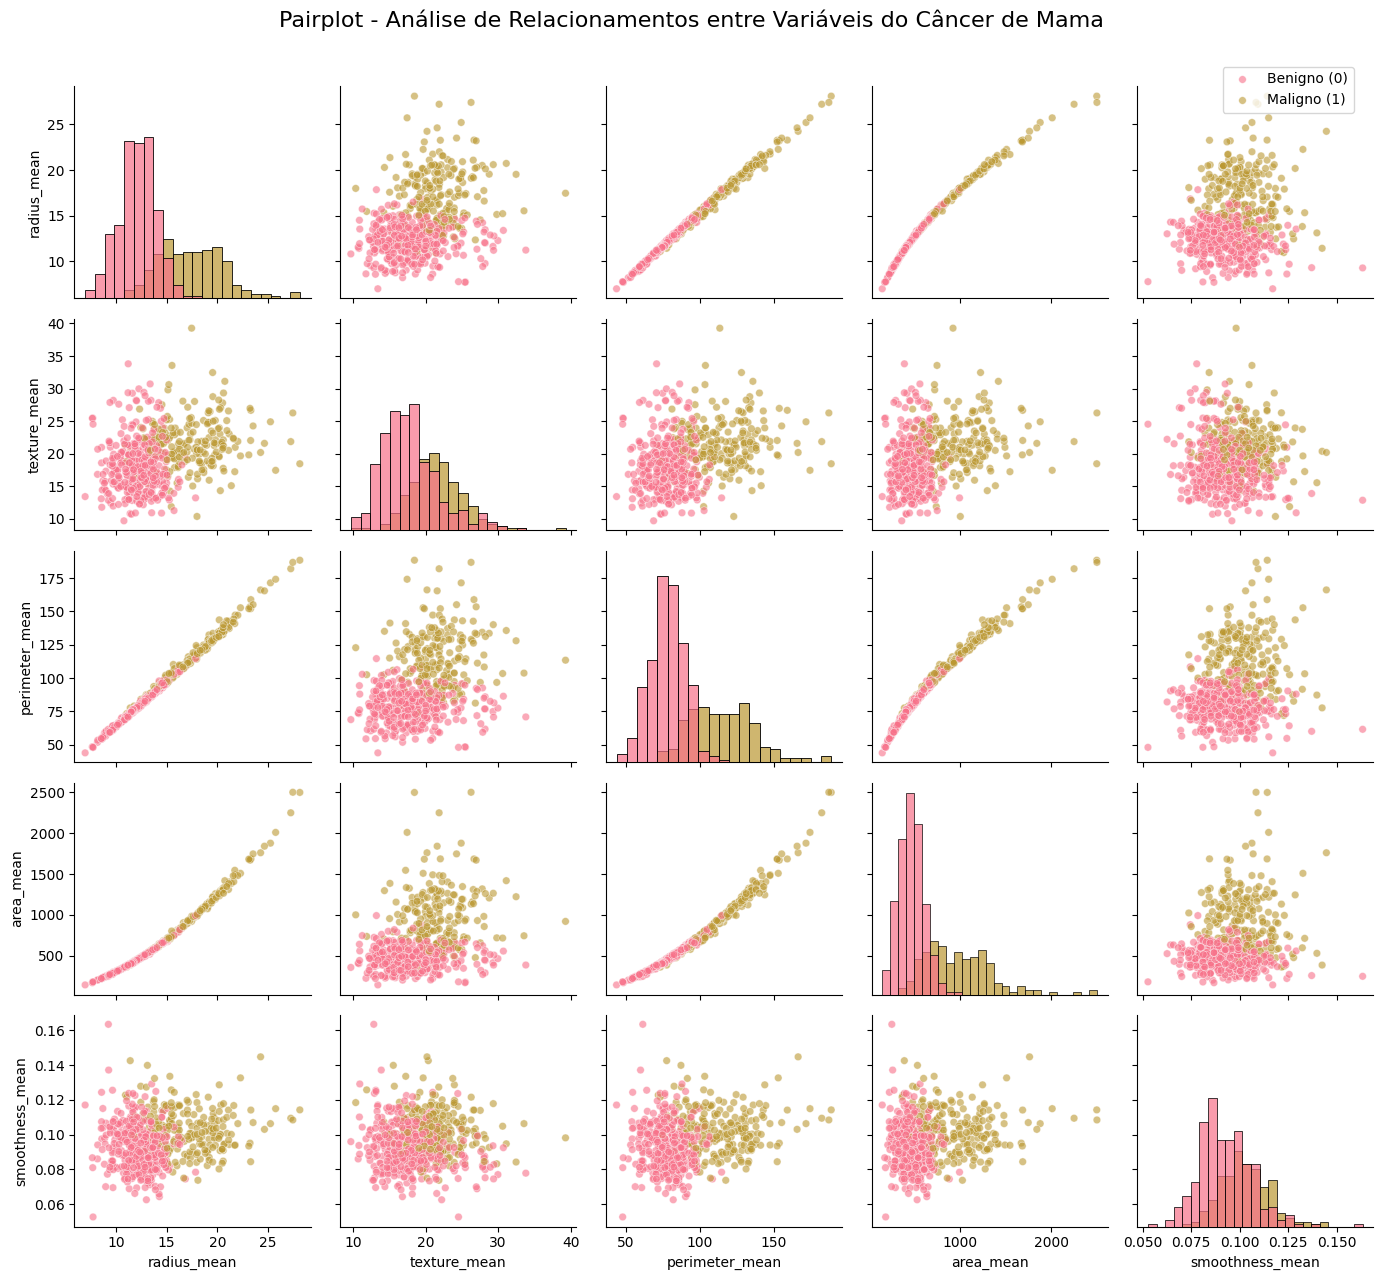

In [10]:
# Configurar o estilo do seaborn
plt.style.use('default')
sns.set_palette("husl")

# Criar o pairplot
fig = plt.figure(figsize=(15, 12))

# Pairplot com separação por classe
pairplot = sns.pairplot(
    df_subset, 
    hue='diagnosis_encoded',
    diag_kind='hist',
    plot_kws={'alpha': 0.6, 's': 30},
    diag_kws={'alpha': 0.7}
)

# Personalizar o gráfico
pairplot.fig.suptitle('Pairplot - Análise de Relacionamentos entre Variáveis do Câncer de Mama', 
                      fontsize=16, y=1.02)

# Ajustar as legendas
handles = pairplot._legend_data.values()
labels = ['Benigno (0)', 'Maligno (1)']
pairplot.fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))

# Remover a legenda original
pairplot._legend.remove()

plt.tight_layout()
plt.show()

**Análise do Pairplot:**

1. **Correlações Fortes**: Observamos correlações muito fortes entre `radius_mean`, `perimeter_mean` e `area_mean`, 
   o que é esperado geometricamente (raio, perímetro e área estão matematicamente relacionados).

2. **Separabilidade das Classes**: 
   - Tumores malignos (classe 1) tendem a ter valores maiores de raio, perímetro e área
   - Existe uma boa separação visual entre as classes em várias combinações de variáveis
   - A textura também mostra alguma capacidade discriminativa

3. **Distribuições**: 
   - As distribuições na diagonal mostram que algumas variáveis podem se beneficiar de normalização
   - Há evidência de que as classes têm distribuições diferentes para a maioria das variáveis

4. **Implicações para a Rede Neural**:
   - A forte correlação entre algumas variáveis sugere que podemos considerar redução de dimensionalidade
   - A boa separabilidade visual indica que uma rede neural deve conseguir aprender padrões discriminativos
   - A necessidade de normalização é evidente devido às diferentes escalas das variáveis

É possível verificar que o dataset original possui 33 colunas, das quais uma ('Unamed: 32') possui apenas dados nulos.

Além disso, com execeção da coluna 'diagnosis' (que é uma coluna categórica), as demais colunas são colunas numéricas, com informações sobre cada paciente.

### 3.2. Análise da distribuição dos dados

In [11]:
# Análise da distribuição da variável target
print(f"Distribuição da variável target:")

print(df['diagnosis'].value_counts())

print(f"\nPercentual da distribuição da variável target:")

print(df['diagnosis'].value_counts(normalize=True) * 100)

Distribuição da variável target:
diagnosis
B    357
M    212
Name: count, dtype: int64

Percentual da distribuição da variável target:
diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64


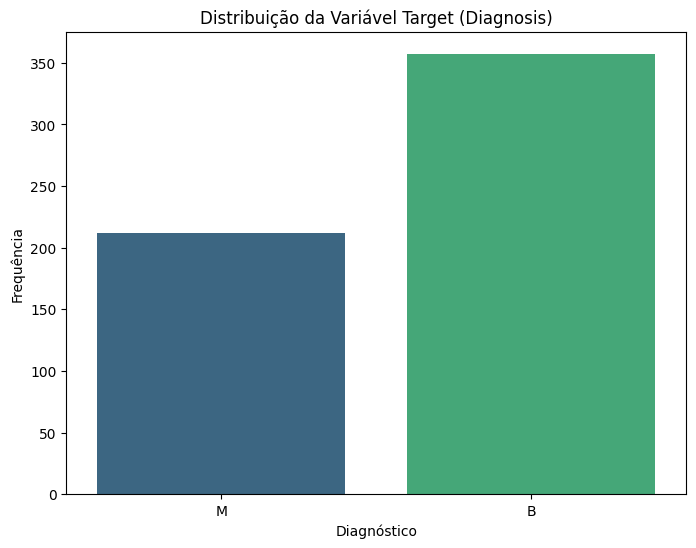

In [12]:
# Visualização da distribuição da variável target
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='diagnosis', palette='viridis')
plt.title('Distribuição da Variável Target (Diagnosis)')
plt.xlabel('Diagnóstico')
plt.ylabel('Frequência')
plt.show()

## Parte 04. Tratamento dos dados (exclusão da coluna nula)

---

<a href='#índice'>Voltar ao início</a>

In [13]:
# Removendo a coluna com valores nulos
df = df.drop('Unnamed: 32', axis=1)
print(f"Novo shape do dataset: {df.shape}")

Novo shape do dataset: (569, 32)


## Parte 05. Verificando a correlação entre as colunas

---

<a href='#índice'>Voltar ao início</a>

In [14]:
# Codificando a variável target para análise de correlação
le = LabelEncoder()
df['diagnosis_encoded'] = le.fit_transform(df['diagnosis'])
print(f"Mapeamento: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Mapeamento: {'B': np.int64(0), 'M': np.int64(1)}


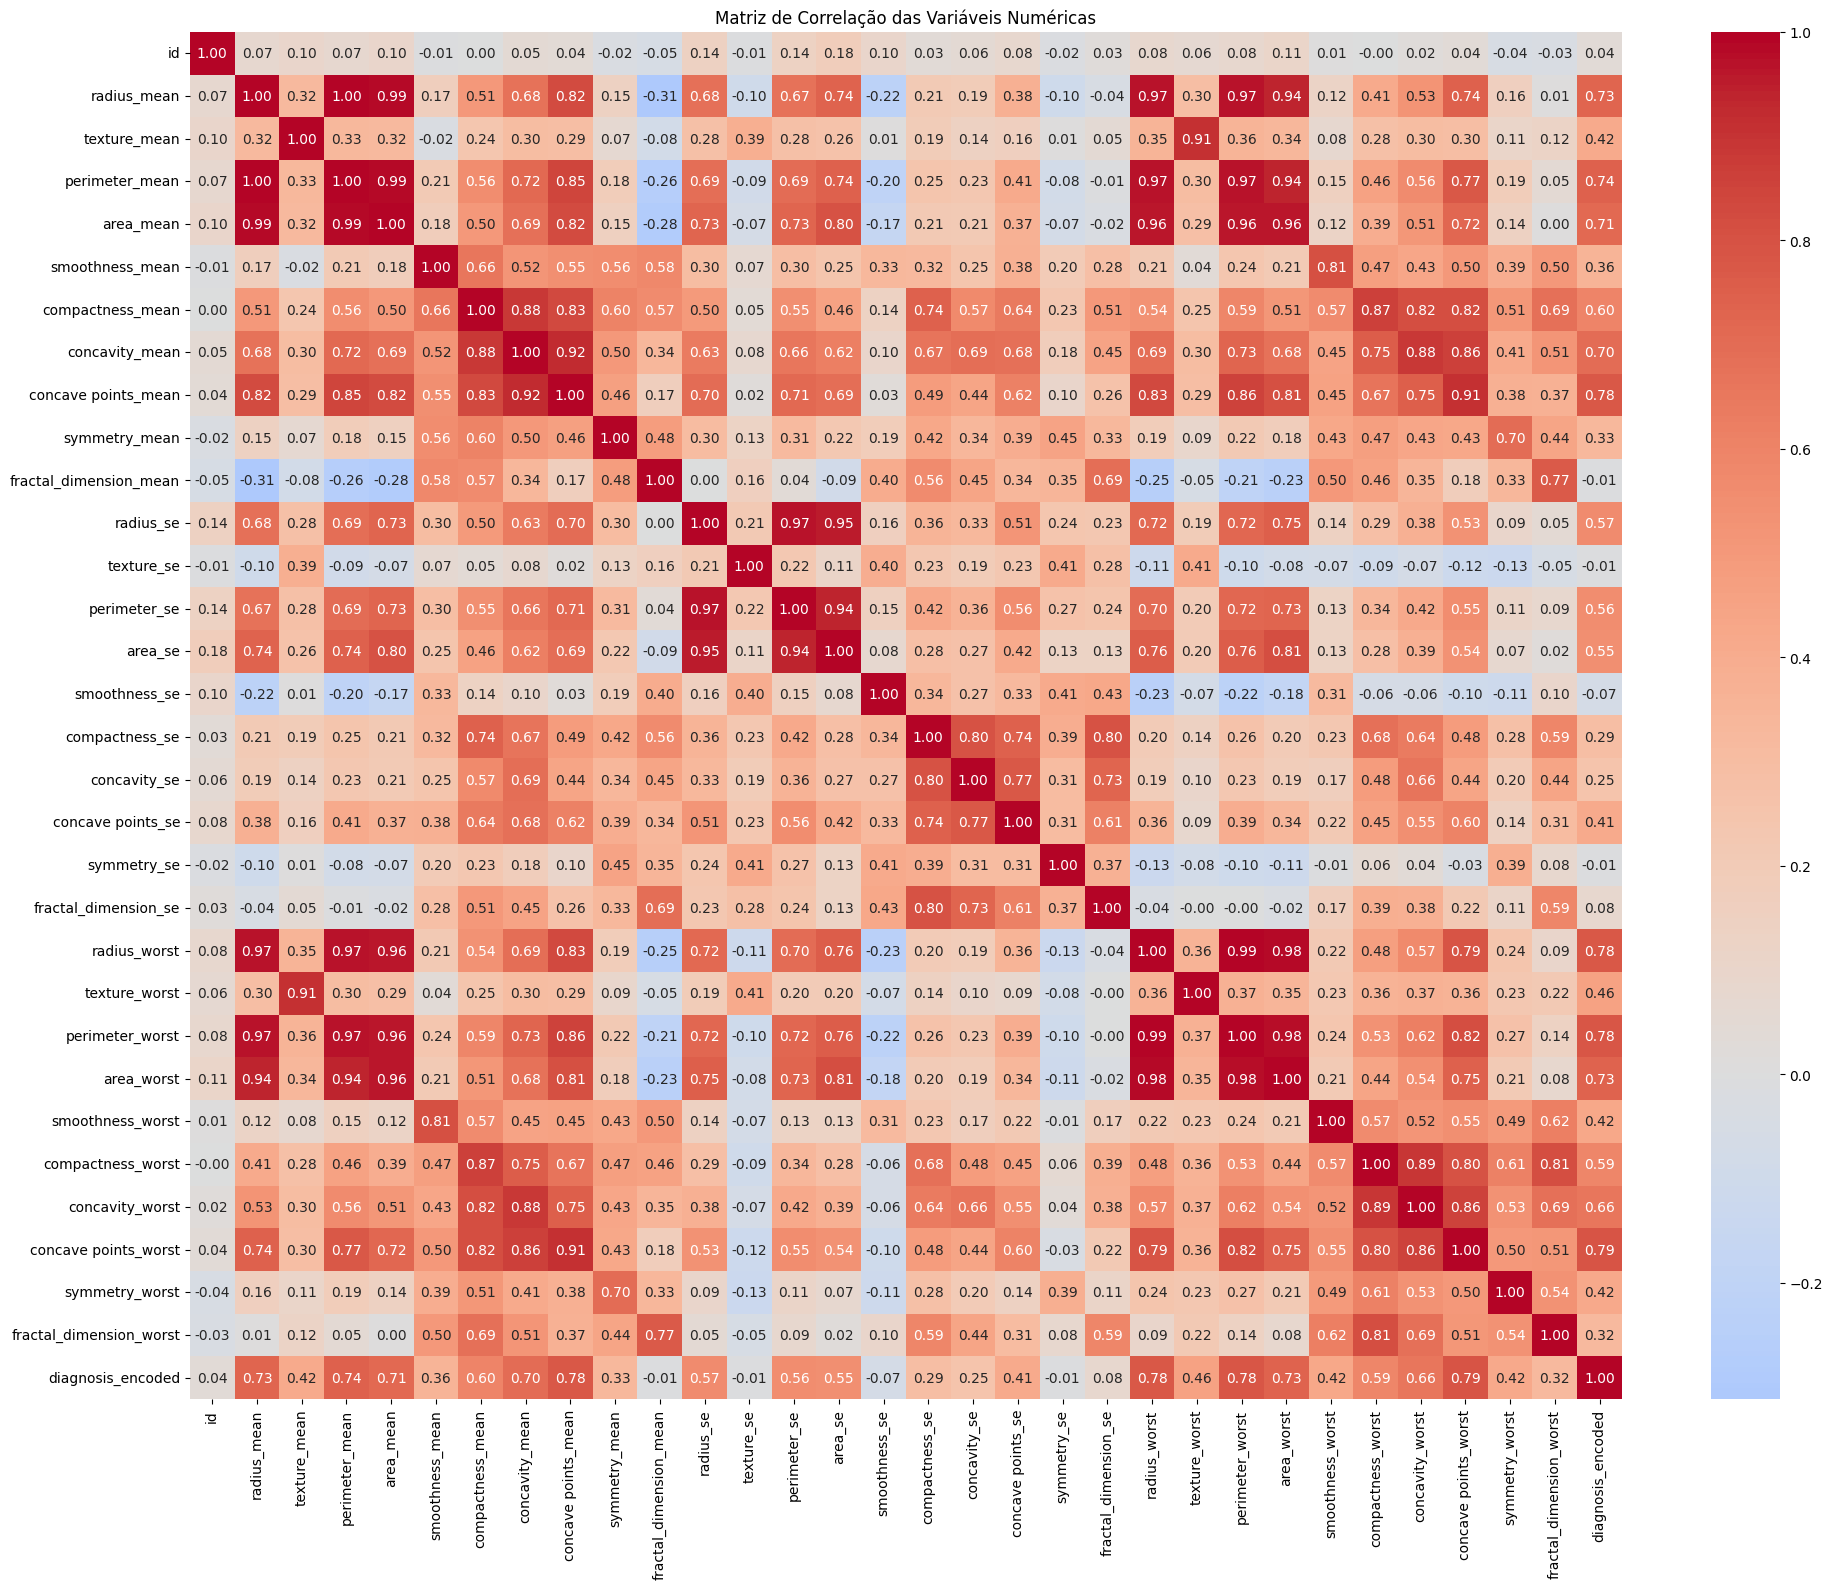

In [15]:
# Matriz de correlação
plt.figure(figsize=(20, 16))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()
plt.show()

## Parte 06. Separar as features utilizadas

---

<a href='#índice'>Voltar ao início</a>

In [16]:
# Separando features e target
X = df.drop(['id', 'diagnosis', 'diagnosis_encoded'], axis=1)
y = df['diagnosis_encoded']

print(f"Shape das features (X): {X.shape}")
print(f"Shape do target (y): {y.shape}")

Shape das features (X): (569, 30)
Shape do target (y): (569,)


## Parte 07. Normalização com o Standard Scaler

---

<a href='#índice'>Voltar ao início</a>

In [17]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (455, 30)
Shape X_test: (114, 30)
Shape y_train: (455,)
Shape y_test: (114,)


In [18]:
# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Média antes da normalização: {X_train.mean().mean():.4f}")
print(f"Desvio padrão antes da normalização: {X_train.std().mean():.4f}")
print(f"Média após a normalização: {X_train_scaled.mean():.4f}")
print(f"Desvio padrão após a normalização: {X_train_scaled.std():.4f}")

Média antes da normalização: 62.4573
Desvio padrão antes da normalização: 35.7565
Média após a normalização: 0.0000
Desvio padrão após a normalização: 1.0000


## Parte 08. Modelos baseline

---

<a href='#índice'>Voltar ao início</a>

### 8.1. Criando um dumb model (baseline) prevendo tudo como a classe majoritária para validações futuras

In [19]:
# Dumb model - sempre prediz a classe majoritária
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_model.fit(X_train_scaled, y_train)

# Predições
y_pred_dummy = dummy_model.predict(X_test_scaled)

# Métricas
print("=== DUMB MODEL (Baseline) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dummy):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dummy):.4f}")

=== DUMB MODEL (Baseline) ===
Accuracy: 0.6316
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


### 8.2. Criando um baseline de Keras padrão (sem nenhum fine-tuning)

In [20]:
# Modelo baseline com Keras
def create_baseline_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Criando e treinando o modelo
baseline_model = create_baseline_model()

# Treinamento
history_baseline = baseline_model.fit(X_train_scaled, y_train,
                                     epochs=100,
                                     batch_size=32,
                                     validation_split=0.2,
                                     verbose=0)

# Predições
y_pred_baseline_prob = baseline_model.predict(X_test_scaled)
y_pred_baseline = (y_pred_baseline_prob > 0.5).astype(int).flatten()

# Métricas
print("=== KERAS BASELINE MODEL ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== KERAS BASELINE MODEL ===
Accuracy: 0.9825
Precision: 1.0000
Recall: 0.9524
F1-Score: 0.9756


## Parte 09. Grid search com validação cruzada

---

<a href='#índice'>Voltar ao início</a>

In [21]:
# Função para criar modelo para grid search
def create_model(neurons=64, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons//2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall()])
    
    return model

In [22]:
K.clear_session()

early_stopping_monitor = EarlyStopping(
    monitor='val_recall',
    patience=10,
    verbose=1
)

# Grid search com validação cruzada
keras_classifier = KerasClassifier(model=create_model, epochs=200, batch_size=32, verbose=1, callbacks=[early_stopping_monitor])

# Parâmetros para grid search
param_grid = {
    'model__neurons': [2, 5, 7],
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.1, 0.2, 0.3]
}

fit_params = {
    'validation_data': (X_test, y_test)
}

# Grid search
grid_search = GridSearchCV(estimator=keras_classifier,
                          param_grid=param_grid,
                          cv=3,
                          scoring='recall',
                          n_jobs=-1,
                          verbose=1)

# Executar grid search
print("Executando Grid Search...")
grid_result = grid_search.fit(X_train_scaled, y_train,**fit_params)

# Melhores parâmetros
print(f"Melhores parâmetros: {grid_result.best_params_}")
print(f"Melhor score: {grid_result.best_score_:.4f}")


Executando Grid Search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0266 - recall: 0.9176 - val_loss: 68.9531 - val_recall: 1.0000
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8682 - recall: 0.9529 - val_loss: 71.9900 - val_recall: 1.0000
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7682 - recall: 0.9118 - val_loss: 74.5231 - val_recall: 1.0000
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6938 - recall: 0.9000 - val_loss: 78.2969 - val_recall: 1.0000
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6347 - recall: 0.9294 - val_loss: 84.8504 - val_recall: 1.0000
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5922 - recall: 0.9412 - val_loss: 91.6199 - val_recall: 1.0000
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5893 - recall: 0.9235 - val_loss: 98.1832 - val_recall: 1.0000
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6

In [23]:
# Avaliação do melhor modelo
best_model = grid_result.best_estimator_

# Predições
y_pred_best_prob = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred_best = best_model.predict(X_test_scaled)

# Métricas
print("=== MELHOR MODELO (Grid Search) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_best_prob):.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
=== MELHOR MODELO (Grid Search) ===
Accuracy: 0.8860
Precision: 0.7636
Recall: 1.0000
F1-Score: 0.8660
ROC AUC: 0.9745


## Parte 10. Comparação dos modelos

---

<a href='#índice'>Voltar ao início</a>

In [24]:
# Comparação dos modelos
models_comparison = pd.DataFrame({
    'Modelo': ['Dumb Classifier', 'Keras Baseline', 'Melhor Modelo (Grid Search)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dummy),
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_best)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dummy),
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_best)
    ],
    'Recall': [
        recall_score(y_test, y_pred_dummy),
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_best)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dummy),
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_best)
    ]
})

print("=== COMPARAÇÃO DOS MODELOS ===")
print(models_comparison.round(4))

=== COMPARAÇÃO DOS MODELOS ===
                        Modelo  Accuracy  Precision  Recall  F1-Score
0              Dumb Classifier    0.6316     0.0000  0.0000    0.0000
1               Keras Baseline    0.9825     1.0000  0.9524    0.9756
2  Melhor Modelo (Grid Search)    0.8860     0.7636  1.0000    0.8660


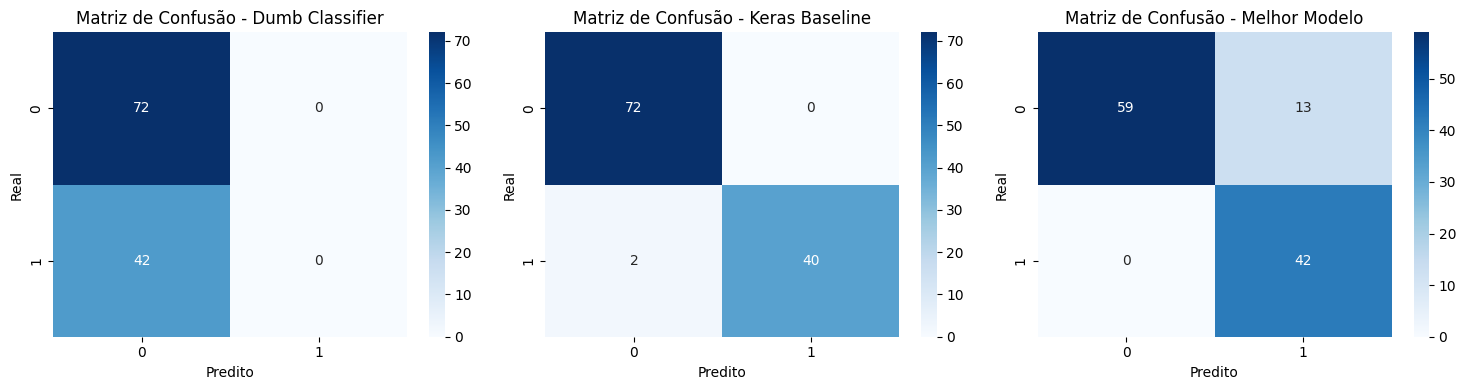

In [25]:
# Matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_preds = [y_pred_dummy, y_pred_baseline, y_pred_best]
model_names = ['Dumb Classifier', 'Keras Baseline', 'Melhor Modelo']

for i, (pred, name) in enumerate(zip(models_preds, model_names)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusão - {name}')
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

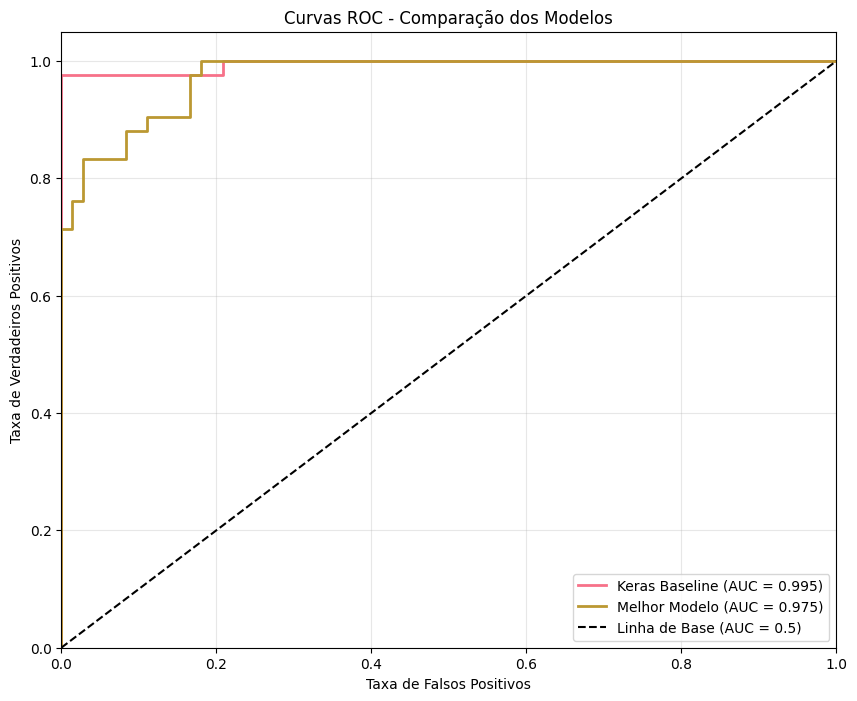

In [26]:
# Curvas ROC
plt.figure(figsize=(10, 8))

# ROC para baseline
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline_prob.flatten())
auc_baseline = auc(fpr_baseline, tpr_baseline)

# ROC para melhor modelo
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_best_prob)
auc_best = auc(fpr_best, tpr_best)

# Plot
plt.plot(fpr_baseline, tpr_baseline, label=f'Keras Baseline (AUC = {auc_baseline:.3f})', linewidth=2)
plt.plot(fpr_best, tpr_best, label=f'Melhor Modelo (AUC = {auc_best:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Linha de Base (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação dos Modelos')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

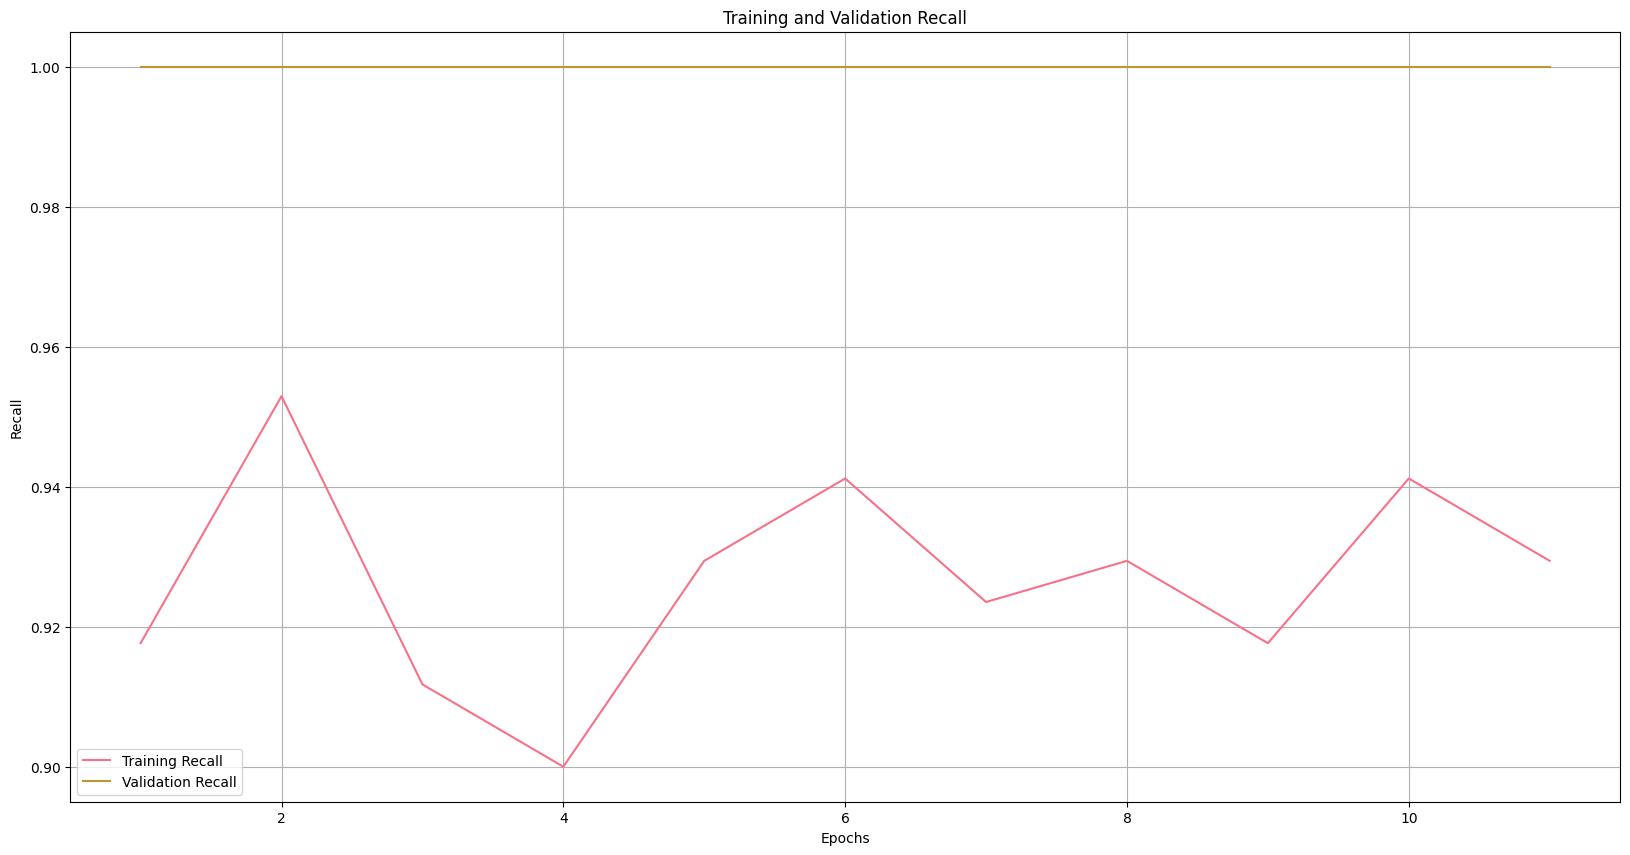

In [27]:
recall = best_model.history_['recall']
val_recall = best_model.history_['val_recall']
epochs = range(1, len(recall) + 1)

plt.figure(figsize=(20, 10))
plt.plot(epochs, recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

## Parte 11. Streamlit

---

<a href='#índice'>Voltar ao início</a>

*Nota: A implementação do Streamlit será feita apenas na pipeline de produção.*